In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque
from scipy.stats import bernoulli, binom

# Setup

Assume we have two Bernoulli-distributed random variables $X$ and $Y$ with known marginal distributions.

$$
\begin{align}
X &\sim \text{Bernoulli}(p) \\
Y &\sim \text{Bernoulli}(q)
\end{align}
$$

We are interested in determining whether there is a correlation between $X$ and $Y$
based on $n$ observations of $(x, y)$ pairs.
We can do this by Bayesian hypothesis testing within the model
$$
\begin{align}
Y \mid X=0 &\sim \text{Bernoulli}(q_0) \\
Y \mid X=1 &\sim \text{Bernoulli}(q_1) \\
\end{align}
$$
under the constraint that $(1-p) q_0 + p q_1 = q\ $  to maintain the marginal distribution over $Y$.

Because the order of observations does not matter, we transform the $(x, y)$ pairs into summary
counts and model those counts with Binomial distributions. 
First we determine how many datapoints will have $X = 1$.
Then, for each subset, we determine how many will have $Y = 1$.

$$
\begin{align}
n_1 &\sim \text{Binomial}(n, p) \\
n_0 &= n - n_1 \\
k_0 &\sim \text{Binomial}(n_0, q_0) \\
k_1 &\sim \text{Binomial}(n_1, q_1) \\
\end{align}
$$

We can then express the data as a contingency table $C$ where $C_{x,y}$ indicates the counts for
the corresponding $(x, y)$ pair.
$$
C = \begin{bmatrix}
    n_0 - k_0 & k_0 \\
    n_1 - k_1 & k1 \\
\end{bmatrix}
$$

$C$ has the following expected proportions, a fact we will employ later.
$$
% \newcommand{\ecr}{\mathbb{E}\left(\frac{C}{n}\right)}
\newcommand{\ecr}{\overline{C}}
\ecr = \begin{bmatrix}
    (1-p) (1-q_0)  & (1-p) q_0 \\
    p (1-q_1) & p q_1 \\
\end{bmatrix}
$$

The expected correlation coefficient is
$$
\phi = {\frac {\ecr_{11}\ecr_{00}-\ecr_{10}\ecr_{01}} {\sqrt {\ecr_{1\bullet }\ecr_{0\bullet }\ecr_{\bullet 0}\ecr_{\bullet 1}}}}.
$$

In [2]:
def get_q1(p, q, q0):
    """Choose q1 such that the marginal q is maintained."""
    return(q - (1-p) * q0) / p

def get_q0(p, q, q1):
    """Choose q0 such that the marginal q is maintained."""
    return(q - p * q1) / (1-p)

p, q, q0 = .3, .2, .1
q1 = get_q1(p, q, q0)
print(p, q, q0, q1)
assert np.allclose([p * q1 + (1-p) * q0], [q])  # check that marginal holds
assert np.allclose([q0], [get_q0(p, q, q1)])  # check for consistency

0.3 0.2 0.1 0.43333333333333335


In [12]:
X = sample_table(10000, 0.2, 0.4, 0.25) / 10000


In [29]:
np.ravel_multi_index((x, y), (2, 2))

array([3, 1, 0, 2, 1, 0, 0, 2, 1, 0, 0, 3, 3, 0, 0, 0, 0, 2, 0, 3, 0, 0,
       1, 0, 2, 0, 1, 0, 1, 3, 0, 1, 2, 1, 1, 1, 0, 1, 2, 0, 1, 2, 0, 1,
       0, 0, 1, 2, 0, 0, 1, 1, 0, 2, 3, 0, 1, 1, 3, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0,
       3, 2, 0, 2, 0, 1, 2, 1, 0, 0, 2, 1])

In [30]:
x << 1 | y

array([3, 1, 0, 2, 1, 0, 0, 2, 1, 0, 0, 3, 3, 0, 0, 0, 0, 2, 0, 3, 0, 0,
       1, 0, 2, 0, 1, 0, 1, 3, 0, 1, 2, 1, 1, 1, 0, 1, 2, 0, 1, 2, 0, 1,
       0, 0, 1, 2, 0, 0, 1, 1, 0, 2, 3, 0, 1, 1, 3, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0,
       3, 2, 0, 2, 0, 1, 2, 1, 0, 0, 2, 1])

In [24]:
x, y = sequence(100, 0.2, 0.4, 0.25)
obs = x << 1 | y
pd.Series(obs).value_counts()

0    48
1    30
2    14
3     8
dtype: int64

In [13]:
X.ravel()

array([0.4789, 0.3186, 0.1544, 0.0481])

In [3]:
n = 1000
def sample_table(n, p, q0, q1):
    """Sample a contingency table with the given parameters."""
    n1 = binom(n, p).rvs()
    n0 = n - n1
    k0 = binom(n0, q0).rvs()
    k1 = binom(n1, q1).rvs()
    return np.array([[n0 - k0, k0], [n1-k1, k1]])

def expected_cell_rate(p, q0, q1):
    return np.array([
        
        [(1-p) * (1 - q0), (1-p) * q0],
        [p * (1 - q1), p * q1]
    ])

tbl = sample_table(100, p, q0, q1)
print('Counts')
print(tbl)
print('\nExpected Proportions')
print(expected_cell_rate(p, q0, q1))

Counts
[[56  6]
 [24 14]]

Expected Proportions
[[0.63 0.07]
 [0.17 0.13]]


In [4]:
from sympy.solvers import solveset
from sympy import symbols
from sympy.utilities.lambdify import lambdify

def phi(p, q, q0, q1):
    """Expected correlation coefficient."""
    return (q1 - q0) * p * (1-p) * (p * (1-p) * q * (1-q)) ** -0.5

def get_q1(p, q, q0):
    """Choose q1 such that the marginal q is maintained."""
    return(q - (1-p) * q0) / p

p, q, q0, q1, φ = symbols('p q q0 q1 φ', real=True)
q1 = get_q1(p, q, q0)
get_q0 = lambdify([p, q, φ], 
                  solveset(phi(p, q, q0, q1) - φ, q0))

def get_q0_q1(p, q, φ):
    q0 = get_q0(p, q, φ).pop()
    q1 = get_q1(p, q, q0)
    if not (0 <= q0 <= 1) and (0 <= q1 <= 1):
        return np.nan, np.nan
    return q0, q1

In [5]:
from sklearn.metrics import matthews_corrcoef
def sequence(n, p, q0, q1):
    x = bernoulli(p).rvs(n)
    y0 = bernoulli(q0).rvs(n)
    y1 = bernoulli(q1).rvs(n)
    y = np.where(x, y1, y0)
    return x, y

p = 0.3
q = 0.4
q0, q1 = get_q0_q1(p, q, .3)
x, y = sequence(100000, p, q0, q1)
matthews_corrcoef(x, y)

0.29706037040301997

In [6]:
sequence(30, 0.2, 0.4, 0.8)

(array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0]),
 array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1]))

## Priors
The two hypotheses $H_0$ (correlated) and $H_1$ (uncorrelated) are expressed
as priors over the joint distribution $f(q_0, q_1)$. 

$$
\begin{align}
H_0:& f(q_0, q_1) \propto \mathbb{1}\{q_0 = q_1 = q\} \\
H_1:& f(q_0, q_1) \propto \mathbb{1}\{(1-p) q_0 + p q_1 = q\} \\
\end{align}
$$

where $\mathbb{1}$ denotes an indicator function.

In [6]:
grid_size = 101
grid = np.linspace(0, 1, grid_size)

def normalize(x):
    x = x.astype(float)
    x /= x.sum()
    return x

def is_equal(x, y):
    return abs(x - y) < 1 / grid_size

from toolz import memoize
@memoize
def h1_prior(p, q):
    Q = p * grid + ((1-p)* grid)[:, None]
    return normalize(is_equal(Q, q))

@memoize
def h0_prior(q):
    return np.diag(normalize(is_equal(grid, q)))

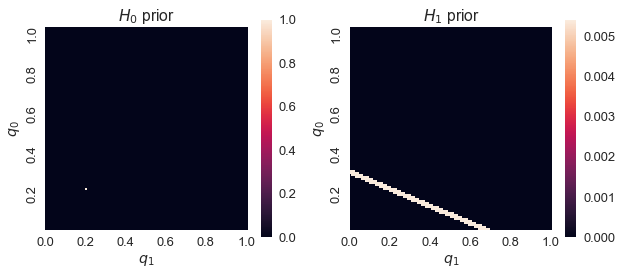

In [7]:
def heatmap(X):
    sns.heatmap(X, xticklabels=20, yticklabels=20, square=True,).invert_yaxis()
    total = X.sum().sum()
    plt.title(f'{total:.2e}')
    plt.xlabel('$q_1$')
    plt.ylabel('$q_0$')
    idx = np.arange(0, 101, 20)
    plt.xticks(idx, idx/100)
    plt.yticks(idx[1:], (idx/100)[1:])
    return total

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(axes[0])
heatmap(h0_prior(0.2))
plt.title('$H_0$ prior')
plt.sca(axes[1])
heatmap(h1_prior(0.3, 0.2))
plt.title('$H_1$ prior');

## Likelihood

Given this data-generating model, we can compute a likelihood
$$
\Pr(n_0, n_1, k_0, k_1 \mid p, q_0, q_1) = 
  \text{Binomial}(n_1; n, p)\ \text{Binomial}(k_0; n_0, p_0)\ \text{Binomial}(k_1; n_1, p_1).
$$

However, for the purposes of a likelihood ratio test, we can ignore the probability of $n_1$
because it is constant under the two hypotheses.

4.264392324096829

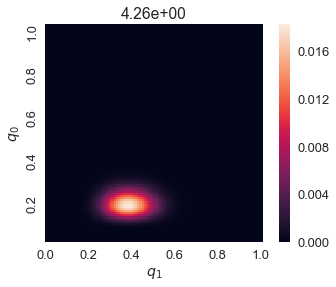

In [8]:
def likelihood_grid(tbl):
    """Binomial likelihood of the counts in tbl for a 2D grid of q0 and q1 values."""
    n0, n1 = tbl.sum(axis=1)  # counts for x
    k0, k1 = tbl[:, 1]  # counts for x given y=1
    pk0 = binom(n0, p=grid).pmf(k0)
    pk1 = binom(n1, p=grid).pmf(k1)
    return np.outer(pk0, pk1)

heatmap(likelihood_grid(tbl))

## Posterior

To compute the posterior probability of each hypothesis, which must integrate out $q_0$ and $q_1$,
weighted by the prior for that hypothesis. We use numerical integration over a fixed-width grid.

Given this data-generating model, we can compute a likelihood
$$
\Pr(n_0, n_1, k_0, k_1 \mid p, q_0, q_1) = 
  \text{Binomial}(n_1; n, p)\ \text{Binomial}(k_0; n_0, p_0)\ \text{Binomial}(k_1; n_1, p_1).
$$

However, for the purposes of a likelihood ratio test, we can ignore the probability of $n_1$
because it is constant under the two hypotheses.

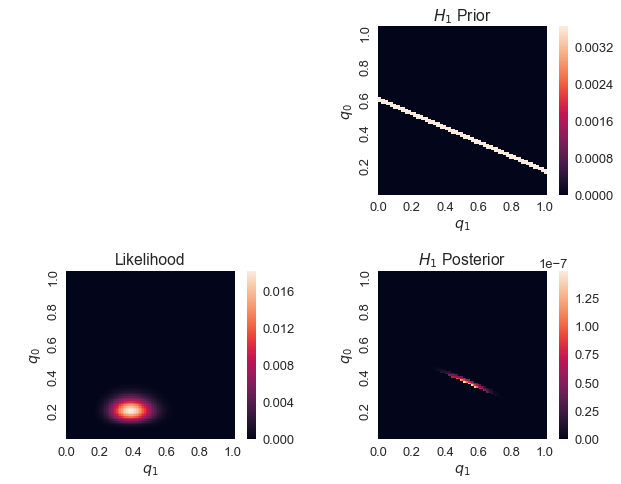

In [9]:
def log_likelihood_ratio(p, q, tbl):
    L = likelihood_grid(tbl)
    h0 = (h0_prior(q) * L).sum()
    h1 = (h1_prior(p, q) * L).sum()
    return np.log(h1) - np.log(h0)

fig, axes = plt.subplots(2, 2, figsize=(9, 7))

axes[0,0].axis('off')
plt.sca(axes[0,1])
heatmap(h1_prior(p, q))
plt.title('$H_1$ Prior')

plt.sca(axes[1,0])
heatmap(likelihood_grid(tbl))
plt.title('Likelihood');

plt.sca(axes[1,1])
heatmap(likelihood_grid(tbl) * h1_prior(p, q))
plt.title('$H_1$ Posterior');
plt.tight_layout()

## Biased memory
So far we have considered _nearly_ exact Bayesian inference (modulo numerical integration error),
in which all the available data is brought to bear equally in the hypothesis test. However, humans
may not have the capacity to remember and/or integrate all available information. What happens if the
learner must "forget" some of the data? We construct a noisily recalled contingency table as

$$
\widetilde{C}_{x,y} \sim \text{Binomial}(C_{x,y}, A_{x,y})
$$

where $A$ is a 2x2 matrix of recollection rates. If $A$ is not constant-valued, memory is biased.

Note that the total expected recollection rate is
$$
\alpha = \sum_{x,y} \ecr_{x,y} A_{x,y}. 
$$

Thus, we can reparameterize to separately control bias $B$ and overal recollection rate $\alpha$.

$$
\begin{align}
\beta   &= \alpha \left( \sum_{x,y} B_{x,y} \ecr_{x,y} \right)^{-1}\\
A_{x,y} &= \beta B_{x,y}
\end{align}
$$

In [10]:
def forget(tbl, mem_rate, bias=None, ecr=None):
    """Stochastically drop (1-mem_rate) proportion of entries in tbl.
    
    If `bias` (a 2x2 array) is given, we make memory rate for each cell 
    proportion to the corresponding element of `bias`. Expected proportions
    of each cell must be provided"""
    if bias is None:
        cell_rates = np.ones(4) * mem_rate
    else:
        beta = mem_rate / np.dot(bias, ecr.flat) 
        cell_rates = beta * bias
    return binom(tbl, cell_rates.reshape((2,2))).rvs()

print(forget(tbl, 0.5))
print(forget(tbl, 0.5, np.array([1,1,1,2]), expected_cell_rate(p, q0, q1)))


[[35  6]
 [ 6  7]]
[[27  4]
 [ 9 12]]


# Simulations

Having formalized the problem of identifying correlations with possibly-biased memory, we now ask:
"Under what circumstances would a learner want to bias her memory?" We explore this through simulations.

In [11]:
def simulate(n, p, q, phi):
    """Evaluate biases of varying stregnth for all 4 cells in a sampled contingency table."""
    q0, q1 = get_q0_q1(p, q, phi)
    if np.isnan(q0):
#         No possible q0/q1 for this combination of p, q, and phi
        return
    ecr = expected_cell_rate(p, q0, q1)
    tbl = sample_table(n, p, q0, q1)
    true_llr = log_likelihood_ratio(p, q, tbl)
    for cell in range(4):
        bias = np.ones(4)
        for cell_bias in np.logspace(0, 3, num=14, base=2):
            bias[cell] = cell_bias
            for mem_rate in np.linspace(0.2, 1, 5):
                try:
                    noisy_tbl = forget(tbl, mem_rate, bias, ecr)
                except ValueError:
                    pass
                else:
                    yield {
                         'n': n, 'p': p, 'q': q, 'phi': phi,
                         'mem_rate': mem_rate, 'q0': q0, 'q1': q1,
                         'cell': cell, 'bias': cell_bias,
                         'llr':  log_likelihood_ratio(p, q, noisy_tbl),
                         'true_llr': true_llr,
                         'empirical_rate': noisy_tbl.sum() / n,
                    }

from toolz import concat
def simulate_many(n, p, q, phi, many=100):
    fn = 'data/' + '_'.join(map(str, [n,p,q,phi]))
    try:
        results = list(concat(simulate(n,p,q,phi) for _ in range(many)))
        df = pd.DataFrame(results)
        df.q0 = df.q0.round(4)
        df.q1 = df.q1.round(4)
        df.to_pickle(fn)
        df.set_index(['n', 'p','q','phi', 'q0', 'q1']).to_pickle(fn)
    except:
        pass

In [12]:
from toolz import concat
def dict_product(d):
    """All possible combinations of values in lists in `d`"""
    for k, v in d.items():
        if not isinstance(v, (list, np.ndarray)):
            d[k] = [v]
    for v in list(it.product(*d.values())):
        yield dict(zip(d.keys(), v))

params = dict_product({
    'n': [30, 60],
    'p': np.linspace(0.1, 0.4, 4),
    'q': np.linspace(0.1, 0.4, 4),
    'phi': np.linspace(0, 0.5, 6),
#     'mem_rate': [0.1, 0.2, 0.3],
})
def run_simulations():
    """This takes a while!"""
    from tqdm import tqdm
    from joblib import Parallel, delayed
    jobs = [delayed(simulate_many)(**prm) for prm in params]
    Parallel(22)(tqdm(jobs))

In [31]:
def read_simulations():
    data = []
    for fn in os.listdir('data'):
        data.append(pd.read_pickle(f'data/{fn}'))
    df = pd.concat(data)
    return df.reset_index()
data = read_simulations()

In [32]:
data['correlated'] = abs(data.q0 - data.q1) > .01
data['guess'] = data.llr > 0
data['correct'] = data.guess == data.correlated
# data['result'] = data.correlated.astype(int).astype(str) + data.guess.astype(int).astype(str)
# data['false_positive'] = data.result == '11'
# data['logbias'] = np.log(data.bias)
# data['logbias_'] = data.logbias.round(2)
data['Cell'] = data.cell.replace({0: '00', 1: '01', 2: '10', 3: '11'})
# data['Bias'] = data.logbias.round(2)
data.q0 = data.q0.round(4)
data.q1 = data.q1.round(4)
# data['Memory'] = data.mem_rate.replace({x: f'{round(x*100)}%' for x in (0.1,0.2,0.3)})
# corr_labels = [
#     'No Correlation\n(0.3 vs 0.3)',
#     'Weak Correlation\n(0.2 vs 0.5)',
#     'Strong Correlation\n(0.1 vs 0.8)',
# ]
# data['correlation'] = pd.Categorical(data.q0.replace(dict(zip([.3, .2, .1], corr_labels))),
#                                      corr_labels, ordered=True)

### Bias towards  $C_{1,1}$

$C_{1,1}$ is the least common element apriori because we asume $p < 0.5$ and $q < 0.5$. Because
large numbers in this cell support a correlation, we expect that biasing memory towards this cell
will overall increase the probability of identifying a correlation (correctly or spuriously). This
is confirmed in the plot below.

In [34]:
data['error'] = abs(data.llr - data.true_llr)

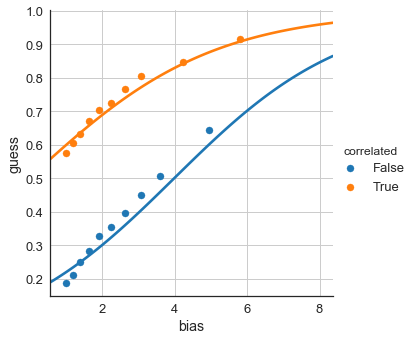

In [35]:
df = data.query('Cell == "11"')
sns.lmplot('bias', 'guess', data=df, hue='correlated', x_bins=14, logistic=True, ci=None)
plt.grid()

Below we plot the probability of answering correctly given for each bias and memory rate level. We see
that a moderate bias tends to be beneficial.

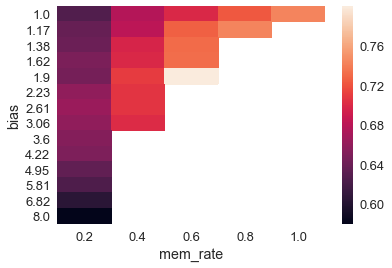

In [36]:
df = data.query('Cell == "11"')
g = df.groupby(['bias', 'mem_rate', 'correlated'])
mask = df.groupby(['bias', 'mem_rate']).correlated.mean() != 1
correct = g.correct.mean().mean(level=[0,1]).loc[mask].unstack()
sns.heatmap(correct, #vmin=0.5, vmax=1, 
            xticklabels=correct.columns.values.round(2),
            yticklabels=correct.index.values.round(2))


In [46]:
from toolz import curry
from tqdm import tqdm

@curry
def progress(func, n_calls=None, best=None):
    _best = None
    pbar = tqdm(total=n_calls)
    def wrapped(*args, **kwargs):
        nonlocal best
        x = func(*args, **kwargs)
        pbar.update()
        if best:
            _best = best(x, _best)
            pbar.set_postfix(best=best, last=x)
        return x
    return wrapped

import time
@progress(n_calls=10)
def wait():
    time.sleep(.2)
    return 1
    
for _ in range(10):
    wait()




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:00<00:01,  4.92it/s]


 20%|██        | 2/10 [00:00<00:01,  4.91it/s]


 30%|███       | 3/10 [00:00<00:01,  4.88it/s]


 40%|████      | 4/10 [00:00<00:01,  4.85it/s]


 50%|█████     | 5/10 [00:01<00:01,  4.85it/s]


 60%|██████    | 6/10 [00:01<00:00,  4.86it/s]


 70%|███████   | 7/10 [00:01<00:00,  4.87it/s]


 80%|████████  | 8/10 [00:01<00:00,  4.88it/s]


 90%|█████████ | 9/10 [00:01<00:00,  4.87it/s]


100%|██████████| 10/10 [00:02<00:00,  4.86it/s]

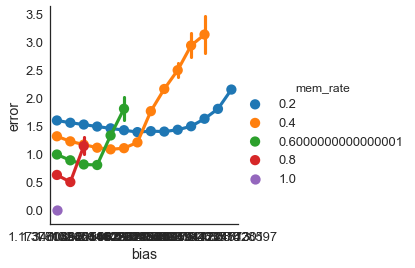

In [40]:
sns.factorplot('bias', 'error', hue='mem_rate', data=df)

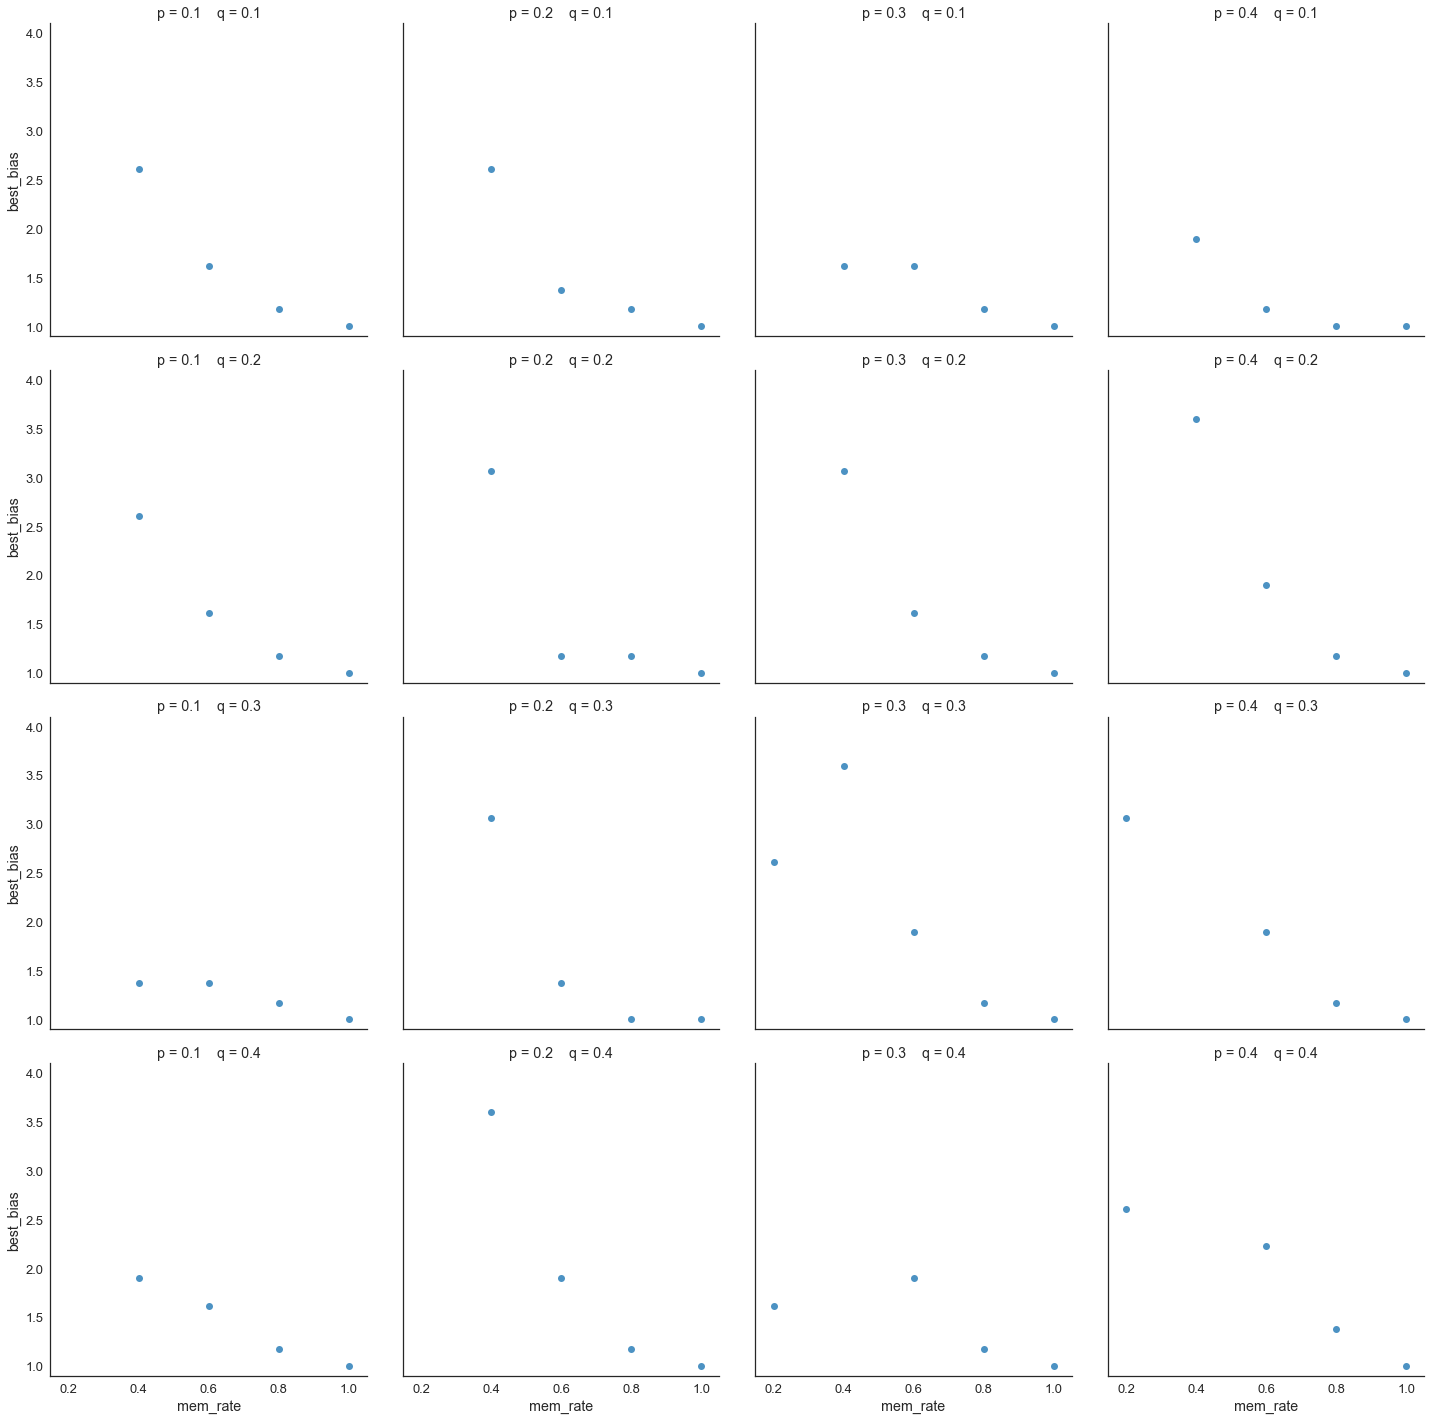

In [29]:
df = data.query('Cell == "11"')

def bias_value(df, group_vars):
    g = df.groupby([*group_vars, 'bias', 'correlated'])
    correct = g.correct.mean().mean(level=list(range(len(group_vars)+1)))
    return correct

def best_bias(df, group_vars):
    return (bias_value(df, group_vars).unstack().idxmax(axis=1)
            .reset_index().rename(columns={0: 'best_bias'}))

g = sns.lmplot('mem_rate', 'best_bias', col='p', row='q',  
               data=best_bias(df, ['p', 'q', 'mem_rate']),
               fit_reg=False)

for ax in g.axes.flat:
    plt.sca(ax)
    plt.ylim(0.9, 4.1)
g.set_titles('p = {col_name:.1f}    q = {row_name:.1f}')

## Optimization

In [18]:
def optimal_bias(n, p, q, phi, mem_rate):
    """Evaluate biases of varying stregnth for all 4 cells in a sampled contingency table."""
    q0, q1 = get_q0_q1(p, q, phi)
    if np.isnan(q0):
#         No possible q0/q1 for this combination of p, q, and phi
        return
    ecr = expected_cell_rate(p, q0, q1)
    def loss(bias):
        tbl = sample_table(n, p, q0, q1)
        true_llr = log_likelihood_ratio(p, q, tbl)
        noisy_tbl = forget(tbl, mem_rate, bias, ecr)
        return log_likelihood_ratio(p, q, noisy_tbl)
        
    for cell in range(4):
        bias = np.ones(4)
        for cell_bias in np.logspace(0, 3, num=14, base=2):
            bias[cell] = cell_bias
            for mem_rate in np.linspace(0.2, 1, 5):
                try:
                    noisy_tbl = forget(tbl, mem_rate, bias, ecr)
                except ValueError:
                    pass
                else:
                    yield {
                         'n': n, 'p': p, 'q': q, 'phi': phi,
                         'mem_rate': mem_rate, 'q0': q0, 'q1': q1,
                         'cell': cell, 'bias': cell_bias,
                         'llr':  log_likelihood_ratio(p, q, noisy_tbl),
                         'true_llr': true_llr,
                         'empirical_rate': noisy_tbl.sum() / n,
                    }

from toolz import concat
def simulate_many(n, p, q, phi, many=100):
    fn = 'data/' + '_'.join(map(str, [n,p,q,phi]))
    try:
        results = list(concat(simulate(n,p,q,phi) for _ in range(many)))
        df = pd.DataFrame(results)
        df.q0 = df.q0.round(4)
        df.q1 = df.q1.round(4)
        df.to_pickle(fn)
        df.set_index(['n', 'p','q','phi', 'q0', 'q1']).to_pickle(fn)
    except:
        pass